In [51]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt
import plotly.graph_objects as go

### Functions

In [52]:
# Normalize between 0 and 1, then multiply by 255
def normalize_img(image):
    image = image.astype(float)
    image -= np.amin(image.astype(float))
    image /= np.amax(image)
    return image * 255

In [53]:
# Load image stack
stack = io.imread('stacks/MAX_DOI_231016_001.nd2 - DOI_231016_001.nd2 (series 1) - C=0.tif')
stack = cv2.resize(stack, (0, 0), fx=.25, fy=.25)

### Mask out background

In [54]:
# Set threshold between 0-255
threshold = 1
# List to store slices
processed_stack = []

for i in range(stack.shape[2]):
    # Apply median blur to target image
    mask = cv2.medianBlur(stack[:,:,i], ksize=5)  # ksize is the kernel size, must be an odd number

    # Normalize mask and target between 0-255
    mask = normalize_img(mask)
    target = normalize_img(stack[:,:,i])

    # Binarize mask
    blank = np.zeros_like(mask)
    binary_mask = np.where(mask < threshold, blank, 1)

    # Mask target slice
    processed_slice = target * binary_mask

    # Add processed slice to stack
    processed_stack.append(processed_slice)

# Convert to numpy array
processed_stack = np.stack(processed_stack, axis=2)

In [55]:
np.max(mask)

255.0

In [56]:
print(processed_slice[:100,:100])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


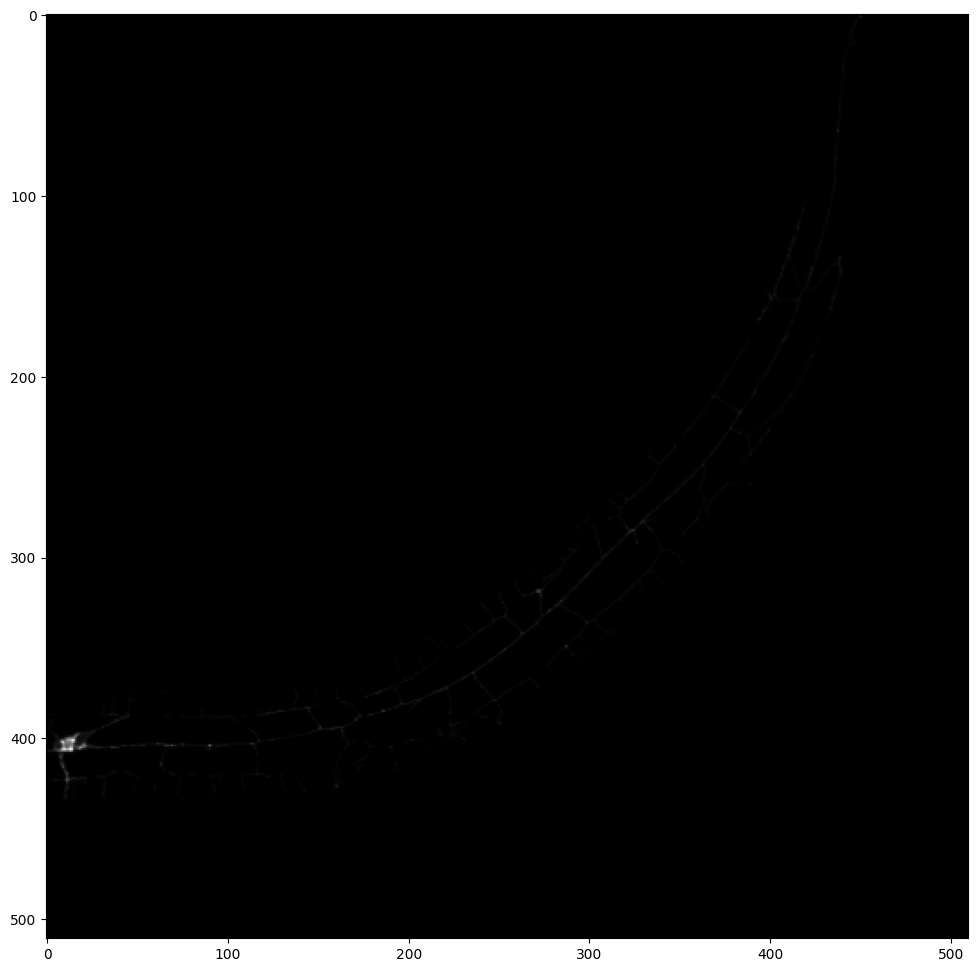

In [57]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(processed_stack[:,:,3], cmap='gray')

In [58]:
print(processed_stack.shape)

(511, 510, 4)


In [64]:
# Prepare data for plotting
x, y, z = processed_stack.shape

Y, X, Z = np.meshgrid(np.arange(y), np.arange(x), np.arange(z))

colors = processed_stack.ravel()  # Flatten the color intensity values

# Separate visible and invisible points
visible_mask = colors != 0
#invisible_mask = colors == 0

# Create a 3D scatter plot with two trace groups
fig = go.Figure()

# Visible points
fig.add_trace(go.Scatter3d(
    x=X.ravel()[visible_mask],
    y=Y.ravel()[visible_mask],
    z=Z.ravel()[visible_mask],
    mode='markers',
    marker=dict(
        size=1,
        color=colors[visible_mask],  # Color based on intensity
        colorscale='Viridis',
        opacity=0.5
    )
))

# # Invisible points
# fig.add_trace(go.Scatter3d(
#     x=X.ravel()[invisible_mask],
#     y=Y.ravel()[invisible_mask],
#     z=Z.ravel()[invisible_mask],
#     mode='markers',
#     marker=dict(
#         size=0,
#         color='rgba(0,0,0,0)',  # Set color to fully transparent
#         opacity=0  # Ensure they are completely invisible
#     )
# ))

# Update layout for better viewing
fig.update_layout(
    title='3D Scatter Plot of Image Stack with Conditionally Invisible Points',
    scene=dict(
        xaxis_title='X (pixels)',
        yaxis_title='Y (pixels)',
        zaxis_title='Z (image index)'
    ),
    autosize=False,
    width=800,
    height=600
)

# Show the figure
fig.show()